In [1]:
#Importando as bibliotecas
import cv2
import numpy as np

#image configs
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('dark_background')
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
matplotlib.rcParams['image.cmap'] = 'gray'
%matplotlib inline

DATA_PATH = r"D:\Estudos\OpenCV\Computer Vision - Introduction\w7 - Geometric Transformations and Image Features\data"

In [2]:
MAX_FEATURES = 1000
MIN_MATCH_COUNT = 10

In [3]:
# Read both images in grayscale mode
img1 = cv2.imread(DATA_PATH + '/images/book.jpeg')
img1Gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.imread(DATA_PATH + '/images/book_scene.jpeg')
img2Gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

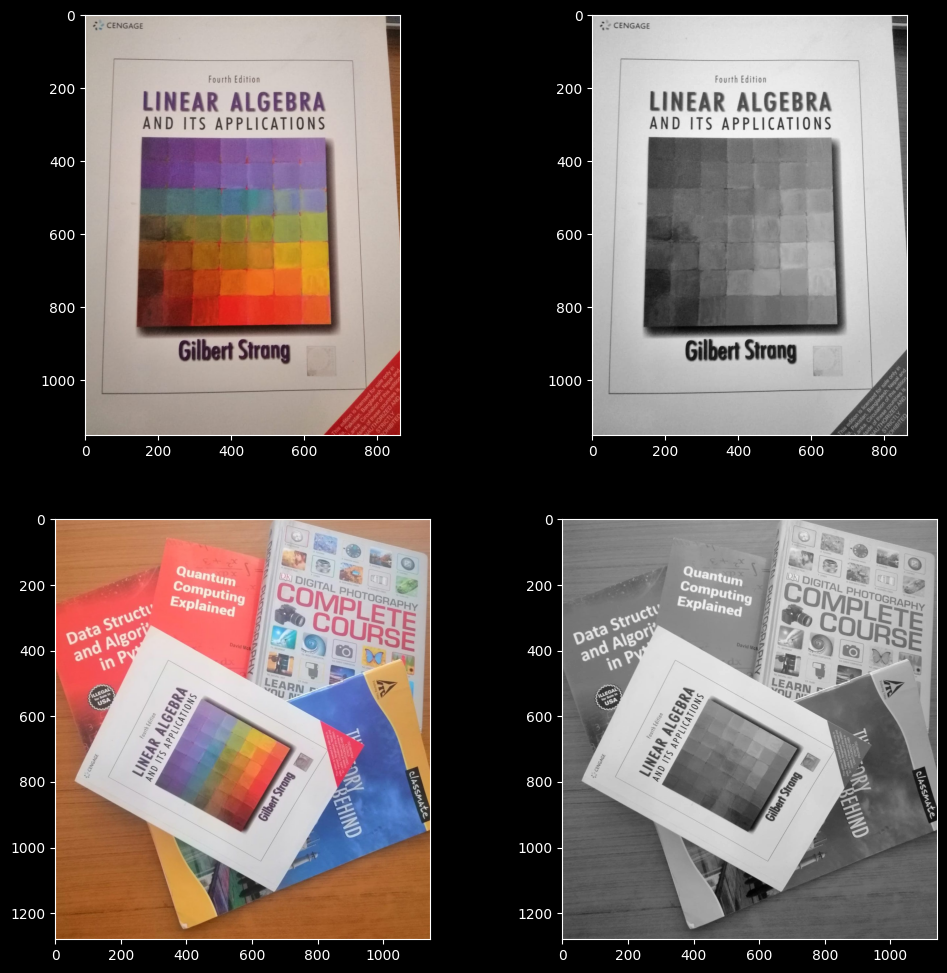

In [4]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(img1[:,:,::-1])
plt.subplot(2,2,2)
plt.imshow(img1Gray,cmap='gray')
plt.subplot(2,2,3)
plt.imshow(img2[:,:,::-1])
plt.subplot(2,2,4)
plt.imshow(img2Gray,cmap='gray')
plt.show()

## Find Features in Both Images

In [5]:
# Detect ORB features and compute descriptors.
orb = cv2.ORB_create(MAX_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(img1Gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2Gray, None)

## Set up the matcher

In [6]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

## Find Matches or Corresponding points

In [7]:
matches = flann.knnMatch(np.float32(descriptors1),np.float32(descriptors2),k=2)

In [9]:
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.9*n.distance:
        good.append(m)


## Find the location of the book in the cluttered image

In [13]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good]).reshape(-1, 1 ,2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good]).reshape(-1, 1 ,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    matchesMask = mask.ravel().tolist()
    h, w, d = img1.shape

    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, M)

    img2 = cv2.polylines(img2, [np.int32(dst)], True, (0,0, 255), 10, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

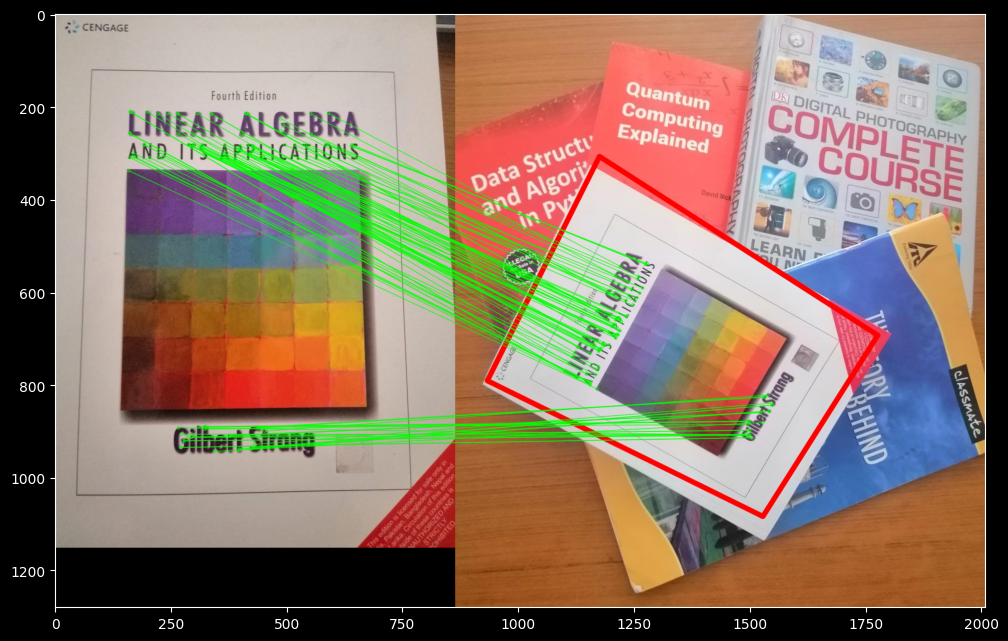

In [15]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img1,keypoints1,img2,keypoints2,good,None,**draw_params)

plt.figure(figsize=(12,12))
plt.imshow(img3[...,::-1]),plt.show();

https://docs.opencv.org/4.1.0/d1/de0/tutorial_py_feature_homography.html
https://circuitdigest.com/tutorial/real-life-object-detection-using-opencv-python-detecting-objects-in-live-video